In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import opera_utils
import pandas as pd
import ultraplot as uplt
import xarray as xr
from rich import print

plt.matplotlib.rcParams["image.cmap"] = "RdBu_r"

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".20"
plt.rcParams["image.cmap"] = "RdBu"


%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
!du -h -d1 | grep zarr

476M	./noaa_gefs.zarr


In [31]:
ds_local = xr.open_zarr("egms_noaa_gefs.zarr", consolidated=False)
ds_local = ds_local.sel(time = slice("2020-07-01", None))
ds_local

<xarray.Dataset> Size: 4GB
Dimensions:                   (time: 15068, latitude: 118, longitude: 264)
Coordinates:
  * time                      (time) datetime64[ns] 121kB 2020-07-01 ... 2025...
    spatial_ref               int64 8B ...
  * longitude                 (longitude) float64 2kB -29.0 -28.75 ... 36.75
  * latitude                  (latitude) float64 944B 71.25 71.0 ... 42.25 42.0
Data variables:
    temperature_2m            (time, latitude, longitude) float32 2GB dask.array<chunksize=(464, 118, 264), meta=np.ndarray>
    categorical_snow_surface  (time, latitude, longitude) float32 2GB dask.array<chunksize=(464, 118, 264), meta=np.ndarray>
Attributes:
    dataset_id:          noaa-gefs-analysis
    dataset_version:     0.1.2
    name:                NOAA GEFS analysis
    description:         Weather analysis from the Global Ensemble Forecast S...
    attribution:         NOAA NWS NCEP GEFS data processed by dynamical.org f...
    spatial_domain:      Global
    spatial_resolution:  0.25 degrees (~20km)
    time_domain:         2000-01-01 00:00:00 UTC to Present
    time_resolution:     3.0 hours

In [33]:
%time ds_local = ds_local.load()

CPU times: user 2.4 s, sys: 1.9 s, total: 4.3 s
Wall time: 2.58 s


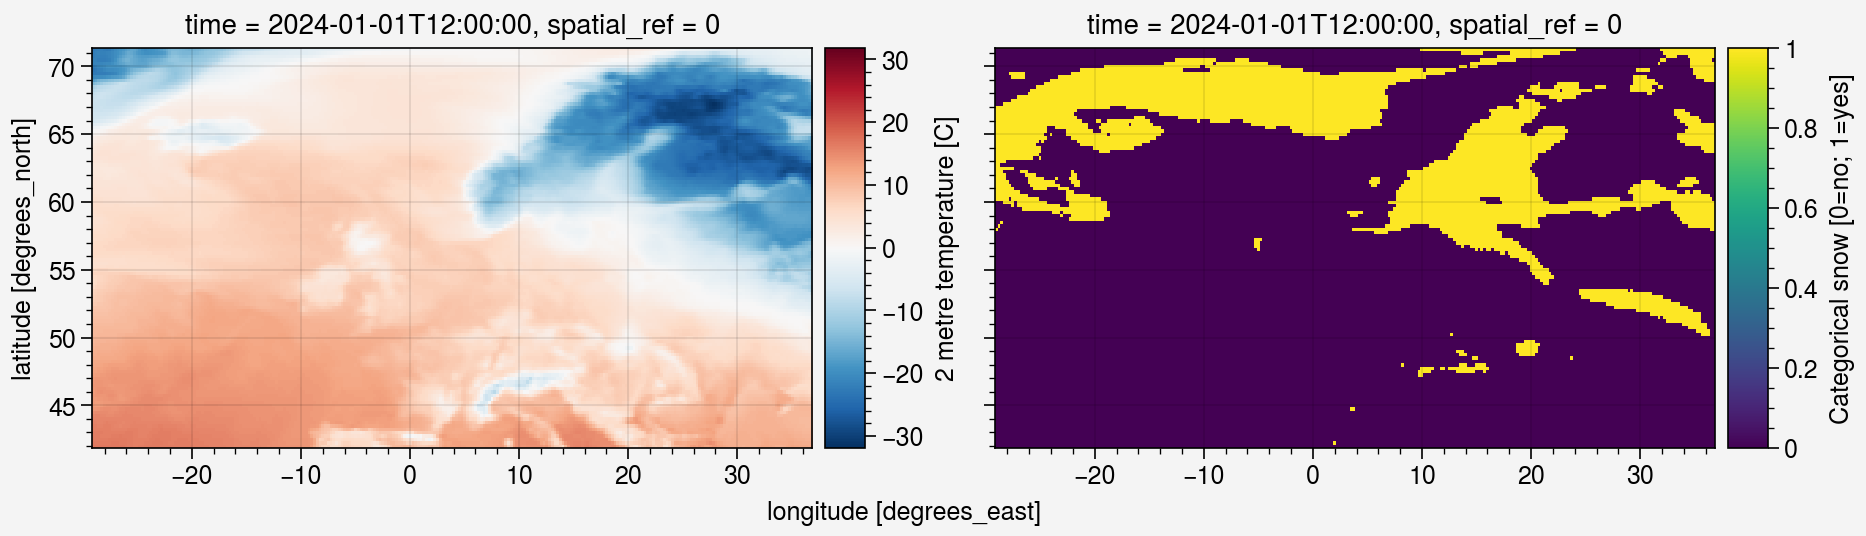

In [34]:
fig, axes = uplt.subplots(ncols=2, refwidth=3.6, refheight=2)

d = ds_local.sel(time="2024-01-01 12:00:00")

d.temperature_2m.plot.imshow(ax=axes[0])
d.categorical_snow_surface.plot.imshow(ax=axes[1])

In [13]:
gdf_frames = opera_utils.get_frame_geodataframe()

gdf_priority = gdf_frames.reset_index()
gdf_priority = gdf_priority.loc[gdf_priority.is_land==1, :]
gdf_priority

frame_id  is_land  is_north_america orbit_pass  \
3             4        1             False  ASCENDING   
4             5        1             False  ASCENDING   
5             6        1             False  ASCENDING   
6             7        1             False  ASCENDING   
7             8        1             False  ASCENDING   
...         ...      ...               ...        ...   
46929     46930        1             False  ASCENDING   
46930     46931        1             False  ASCENDING   
46931     46932        1             False  ASCENDING   
46983     46984        1             False  ASCENDING   
46984     46985        1             False  ASCENDING   

                                                geometry  
3      POLYGON ((2.5319 4.75701, 2.21493 6.28652, 4.4...  
4      POLYGON ((1.93907 7.62125, 4.15397 8.19614, 4....  
5      POLYGON ((1.6639 8.956, 3.88743 9.52738, 4.194...  
6      POLYGON ((1.38921 10.29072, 3.62257 10.85865, ...  
7      POLYGON ((1.11482 11.6254, 3.35926 12.18994, 3...  
...                                                  ...  
46929  POLYGON ((41.22443 -70.94371, 46.07841 -69.404...  
46930  POLYGON ((38.82628 -69.85798, 43.60842 -68.383...  
46931  POLYGON ((36.66122 -68.74407, 41.35214 -67.329...  
46983  POLYGON ((3.86936 -1.60821, 6.05872 -1.00689, ...  
46984  POLYGON ((3.58403 -0.27462, 5.77473 0.32289, 6...  

[21769 rows x 5 columns]

In [14]:
import snow_month_filter as smf

In [15]:
smf.aggregate_weather

<function snow_month_filter.aggregate_weather(ds: 'xr.Dataset', *, snow_var: 'str' = 'categorical_snow_surface', temp_var: 'str' = 'temperature_2m', win: 'str | int' = '1W', snow_agg: 'str' = 'sum') -> 'xr.Dataset'>

In [35]:
%%time
agg = smf.aggregate_weather(ds_local, win="1W")  # or win=72 for hourly roll
agg

CPU times: user 1.45 s, sys: 1.32 s, total: 2.77 s
Wall time: 2.96 s


<xarray.Dataset> Size: 101MB
Dimensions:      (longitude: 264, latitude: 118, time: 270)
Coordinates:
    spatial_ref  int64 8B 0
  * longitude    (longitude) float64 2kB -29.0 -28.75 -28.5 ... 36.25 36.5 36.75
  * latitude     (latitude) float64 944B 71.25 71.0 70.75 ... 42.5 42.25 42.0
  * time         (time) datetime64[ns] 2kB 2020-07-05 2020-07-12 ... 2025-08-31
Data variables:
    snow         (time, latitude, longitude) float32 34MB 1.5 1.125 ... 0.0 0.0
    tmin         (time, latitude, longitude) float32 34MB -0.5933 ... 22.78
    tmax         (time, latitude, longitude) float32 34MB 1.901 1.729 ... 23.22

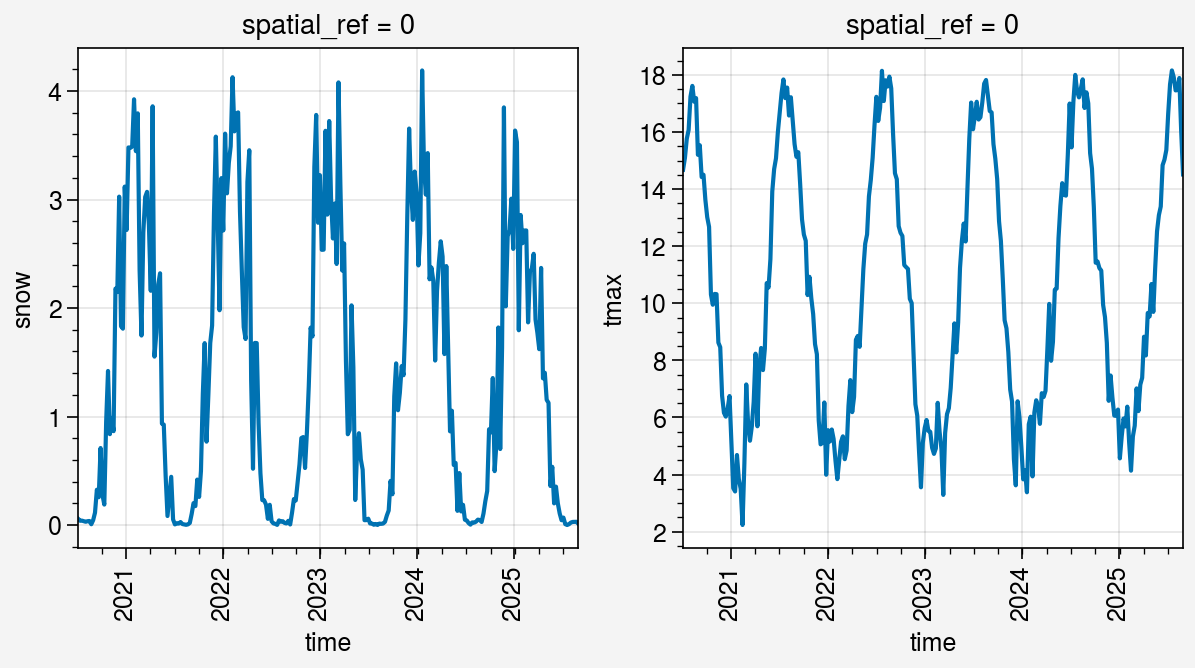

In [36]:
fig, axes = uplt.subplots(ncols=2, share=False)
for ax, var in zip(axes, ["snow", "tmax"]):
    agg[var].mean(dim=("longitude", "latitude")).plot(ax=ax)

In [37]:
mask_3_0 = mask = smf.bad_month_mask(
    agg, snow_threshold=3, freezing_threshold=0, combine="or"
)
mask_4_3 = smf.bad_month_mask(
    agg, snow_threshold=4, freezing_threshold=-3, combine="or"
)
mask.size, mask.sum().item()

(8411040, 2105882)

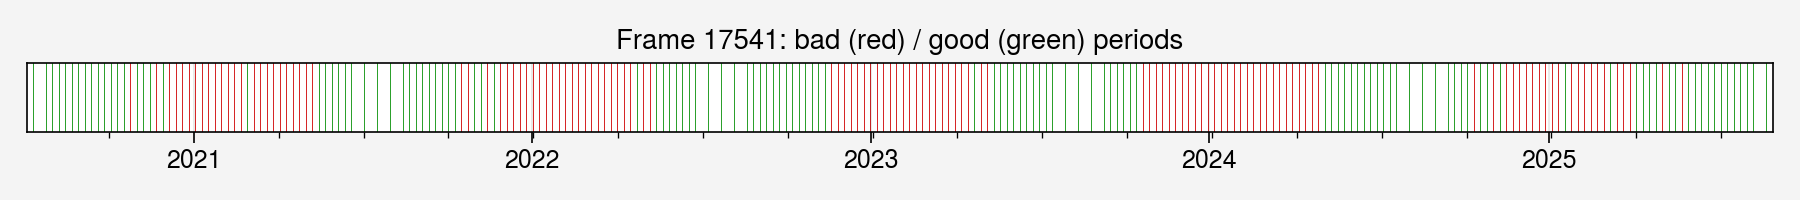

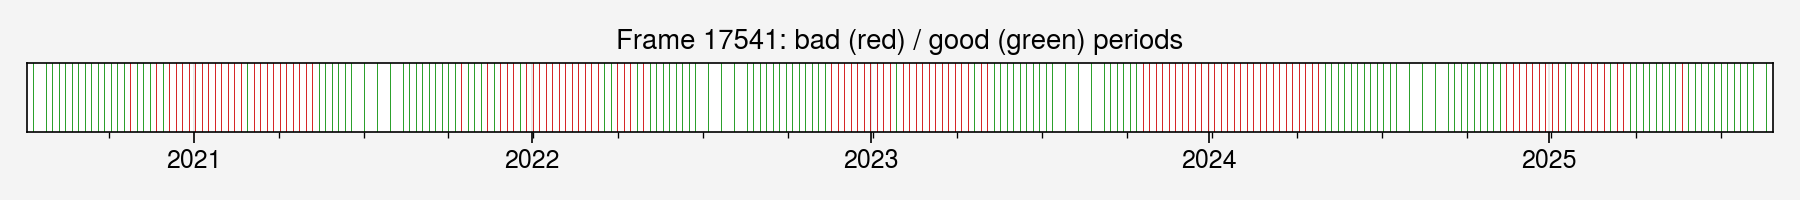

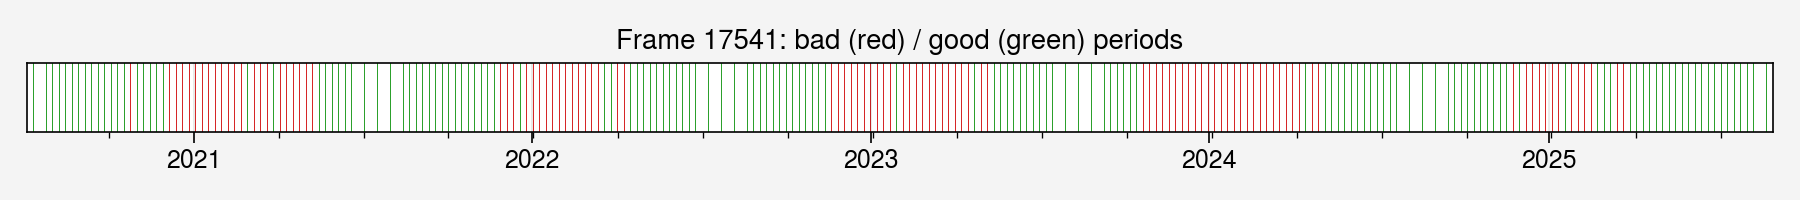

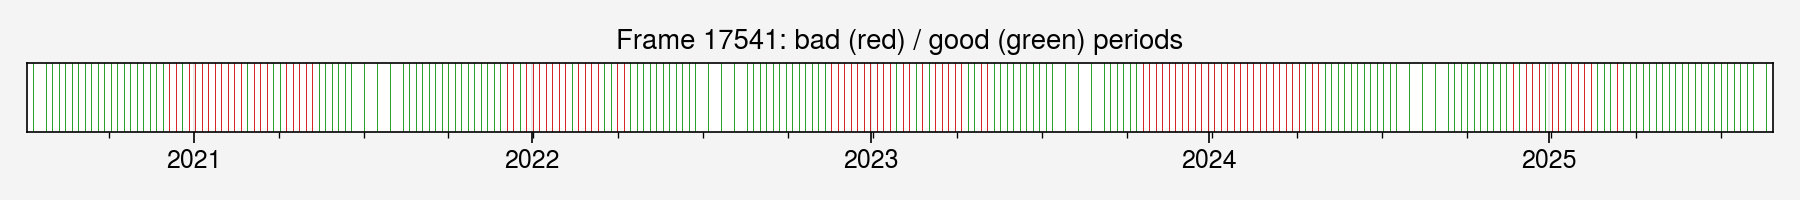

In [38]:
for mask_fraction in [0.1, 0.25, 0.5, 0.75]:
    # print(f"{mask_fraction = }")
    smf.plot_frame_timeline(
        17541,
        smf.bad_month_mask(agg, snow_threshold=3, freezing_threshold=0, combine="or"),
        gdf_priority,
        mask_fraction=mask_fraction,
    )
    plt.show()

In [39]:
# frame_id = 17235  # top of AK
# frame_id = 9451  # top of AK
frame_id = 30710  # three sisters
# frame_id = 42261 # new mexico
frame_id = 17541 # mid norway

poly = gdf_priority.loc[gdf_priority.frame_id == frame_id, "geometry"].iloc[0]
frac = smf.daily_bad_fraction(mask, poly)  # Series indexed by date
frac

time
2020-07-05    0.0
2020-07-12    0.0
2020-07-19    0.0
2020-07-26    0.0
2020-08-02    0.0
             ... 
2025-08-03    0.0
2025-08-10    0.0
2025-08-17    0.0
2025-08-24    0.0
2025-08-31    0.0
Freq: W-SUN, Length: 270, dtype: float64

<Axes: xlabel='time'>

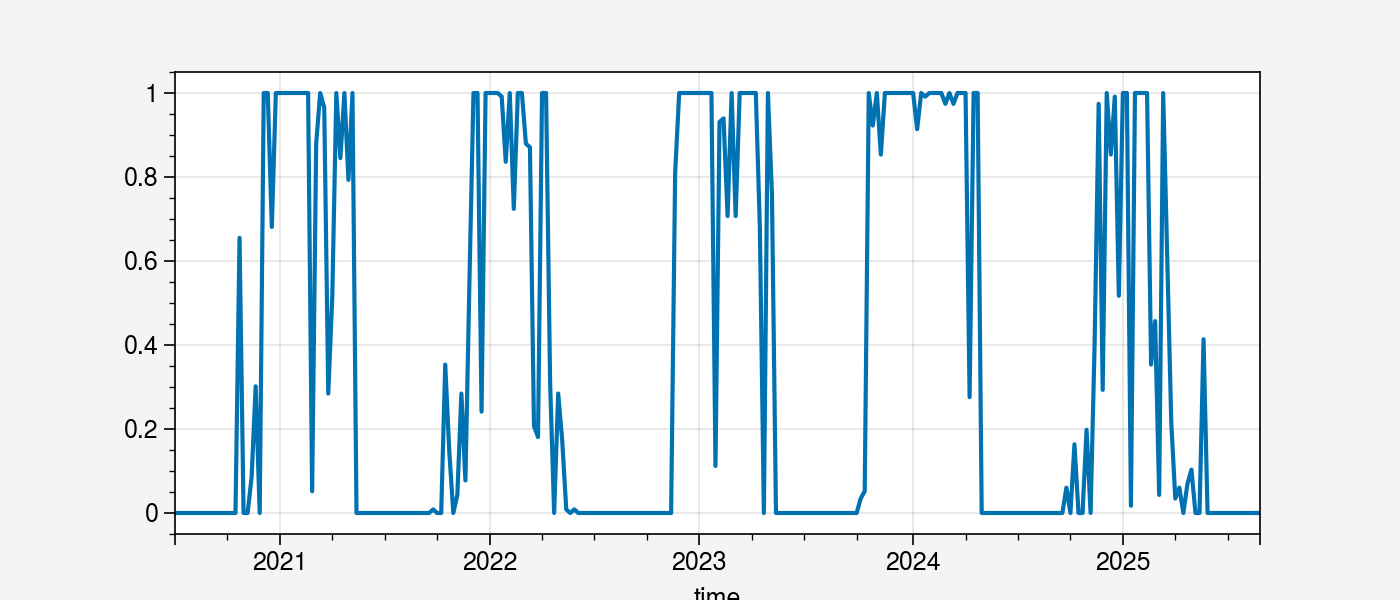

In [40]:
frac.plot(figsize=(7, 3))

In [41]:
runs = smf.get_annual_seasons(frac, mask_fraction=0.3)
runs

[(Timestamp('2020-10-25 00:00:00'), Timestamp('2021-05-09 00:00:00')),
 (Timestamp('2021-10-17 00:00:00'), Timestamp('2022-04-17 00:00:00')),
 (Timestamp('2022-11-20 00:00:00'), Timestamp('2023-05-07 00:00:00')),
 (Timestamp('2023-10-22 00:00:00'), Timestamp('2024-04-28 00:00:00')),
 (Timestamp('2024-11-17 00:00:00'), Timestamp('2025-05-25 00:00:00'))]

In [42]:
print(smf.summarize_blackouts(runs, mode="aggressive"))
print(smf.summarize_blackouts(runs, mode="median"))
print(smf.summarize_blackouts(runs, mode="conservative"))

(Timestamp('2000-11-20 00:00:00'), Timestamp('2001-04-17 00:00:00'))

(Timestamp('2000-10-25 00:00:00'), Timestamp('2001-05-07 00:00:00'))

(Timestamp('2000-10-17 00:00:00'), Timestamp('2001-05-25 00:00:00'))

In [285]:
smf.get_blackout_windows

<function snow_month_filter.get_blackout_windows(agg: 'xr.Dataset', gdf_priority: 'gpd.GeoDataFrame', snow_threshold: 'float' = 3, freezing_threshold: 'float' = -2, temp_var: "Literal['tmin', 'tmax']" = 'tmax', mask_fraction: 'float' = 0.5, frame_id: 'int | None' = None) -> 'dict'>

In [44]:
# frame_id = 17235  # top of AK
# frame_id = 9451  # top of AK
# frame_id = 30710  # three sisters
# frame_id = 42261 # new mexico
# frame_id = 32801 # British columbia glaciers
frame_id = 17541 # mid norway


smf.get_blackout_windows(
    agg.sel(time=slice("2020-07-01", None)),
    gdf_priority,
    temp_var="tmax",
    snow_threshold=4,
    frame_id=frame_id,
).T

Processing frames:   0%|          | 0/1 [00:00<?, ?it/s]

0
frame_id                                      17541
mask_fraction                                   0.5
snow_threshold                                    4
freezing_threshold                               -2
temp_var                                       tmax
start_aggressive                2000-12-08 00:00:00
end_aggressive                  2001-03-16 00:00:00
start_median                    2000-12-05 00:00:00
end_median                      2001-04-28 00:00:00
start_conservative              2000-10-22 00:00:00
end_conservative                2001-05-09 00:00:00
blackout_duration_aggressive                     98
blackout_duration_median                        144
blackout_duration_conservative                  199

In [332]:
smf.get_blackout_windows(
    agg.sel(time=slice("2020-07-01", None)),
    gdf_priority,
    snow_threshold=4,
    temp_var="tmin",
    frame_id=frame_id,
    # mask_fraction=.3
).T

Processing frames:   0%|          | 0/1 [00:00<?, ?it/s]

0
frame_id                                      30710
mask_fraction                                   0.5
snow_threshold                                    4
freezing_threshold                               -2
temp_var                                       tmin
start_aggressive                2000-12-12 00:00:00
end_aggressive                  2001-03-28 00:00:00
start_median                    2000-11-03 00:00:00
end_median                      2001-04-23 00:00:00
start_conservative              2000-10-25 00:00:00
end_conservative                2001-05-15 00:00:00
blackout_duration_aggressive                    106
blackout_duration_median                        171
blackout_duration_conservative                  202

In [47]:
snow_threshold = 4
df_total_tmin = smf.get_blackout_windows(
    agg.sel(time=slice("2020-07-01", None)),
    gdf_priority,
    snow_threshold=snow_threshold,
    temp_var="tmin",
)
df_total_tmax = smf.get_blackout_windows(
    agg.sel(time=slice("2020-07-01", None)),
    gdf_priority,
    snow_threshold=snow_threshold,
    temp_var="tmax",
)

Processing frames:   0%|          | 0/21769 [00:00<?, ?it/s]

Processing frames:   0%|          | 0/21769 [00:00<?, ?it/s]

In [48]:
df_total_tmin.describe().T

count                           mean  \
frame_id                        1169.0                   23514.676647   
mask_fraction                   1169.0                            0.5   
snow_threshold                  1169.0                            4.0   
freezing_threshold              1169.0                           -2.0   
start_aggressive                   996  2000-12-08 07:10:50.602409600   
end_aggressive                     996  2001-03-11 04:15:54.216867584   
start_median                       996  2000-11-21 11:55:39.759036032   
end_median                         996  2001-04-06 19:29:38.313253120   
start_conservative                 996  2000-11-06 04:05:46.987951744   
end_conservative                   996  2001-04-27 23:29:38.313252992   
blackout_duration_aggressive     996.0                      97.282129   
blackout_duration_median         996.0                     136.654618   
blackout_duration_conservative   996.0                     172.808233   

                                                min                  25%  \
frame_id                                       31.0              11579.0   
mask_fraction                                   0.5                  0.5   
snow_threshold                                  4.0                  4.0   
freezing_threshold                             -2.0                 -2.0   
start_aggressive                2000-08-07 00:00:00  2000-11-13 00:00:00   
end_aggressive                  2000-07-02 00:00:00  2001-01-30 00:00:00   
start_median                    2000-08-03 00:00:00  2000-10-24 00:00:00   
end_median                      2000-07-26 00:00:00  2001-03-13 00:00:00   
start_conservative              2000-07-05 00:00:00  2000-10-13 00:00:00   
end_conservative                2000-08-17 00:00:00  2001-04-11 00:00:00   
blackout_duration_aggressive                    1.0                 33.0   
blackout_duration_median                        3.0                 91.0   
blackout_duration_conservative                  7.0                138.0   

                                                50%                  75%  \
frame_id                                    23393.0              35212.0   
mask_fraction                                   0.5                  0.5   
snow_threshold                                  4.0                  4.0   
freezing_threshold                             -2.0                 -2.0   
start_aggressive                2000-12-06 00:00:00  2001-01-10 00:00:00   
end_aggressive                  2001-03-16 00:00:00  2001-04-28 00:00:00   
start_median                    2000-11-24 00:00:00  2000-12-05 00:00:00   
end_median                      2001-04-10 00:00:00  2001-05-09 00:00:00   
start_conservative              2000-11-19 00:00:00  2000-11-24 00:00:00   
end_conservative                2001-04-28 00:00:00  2001-05-16 00:00:00   
blackout_duration_aggressive                   89.0                160.0   
blackout_duration_median                      133.0                196.0   
blackout_duration_conservative                157.0                217.0   

                                                max           std  
frame_id                                    46769.0  13646.451886  
mask_fraction                                   0.5           0.0  
snow_threshold                                  4.0           0.0  
freezing_threshold                             -2.0           0.0  
start_aggressive                2001-03-03 00:00:00           NaN  
end_aggressive                  2001-06-15 00:00:00           NaN  
start_median                    2001-03-03 00:00:00           NaN  
end_median                      2001-06-20 00:00:00           NaN  
start_conservative              2001-02-14 00:00:00           NaN  
end_conservative                2001-06-27 00:00:00           NaN  
blackout_duration_aggressive                  276.0     71.359629  
blackout_duration_median                      285.0     66.89067

In [49]:
df_total_tmax.describe().T

count                           mean  \
frame_id                        1169.0                   23514.676647   
mask_fraction                   1169.0                            0.5   
snow_threshold                  1169.0                            4.0   
freezing_threshold              1169.0                           -2.0   
start_aggressive                   979  2000-12-13 01:41:29.479060352   
end_aggressive                     979  2001-03-10 22:50:52.093973504   
start_median                       979  2000-11-23 23:23:13.667007104   
end_median                         979  2001-04-08 04:05:38.304392192   
start_conservative                 979  2000-11-07 22:09:41.001021440   
end_conservative                   979  2001-04-30 10:26:35.914198144   
blackout_duration_aggressive     979.0                      93.005107   
blackout_duration_median         979.0                     135.420838   
blackout_duration_conservative   979.0                     173.511747   

                                                min                  25%  \
frame_id                                       31.0              11579.0   
mask_fraction                                   0.5                  0.5   
snow_threshold                                  4.0                  4.0   
freezing_threshold                             -2.0                 -2.0   
start_aggressive                2000-08-14 00:00:00  2000-11-20 00:00:00   
end_aggressive                  2000-07-02 00:00:00  2001-02-05 00:00:00   
start_median                    2000-08-04 00:00:00  2000-10-24 00:00:00   
end_median                      2000-07-26 00:00:00  2001-03-13 00:00:00   
start_conservative              2000-07-12 00:00:00  2000-10-13 00:00:00   
end_conservative                2000-08-17 00:00:00  2001-04-11 00:00:00   
blackout_duration_aggressive                    1.0                 25.0   
blackout_duration_median                        4.0                 86.0   
blackout_duration_conservative                  7.0                138.0   

                                                50%                  75%  \
frame_id                                    23393.0              35212.0   
mask_fraction                                   0.5                  0.5   
snow_threshold                                  4.0                  4.0   
freezing_threshold                             -2.0                 -2.0   
start_aggressive                2000-12-11 00:00:00  2001-01-10 00:00:00   
end_aggressive                  2001-03-16 00:00:00  2001-04-28 00:00:00   
start_median                    2000-11-26 00:00:00  2000-12-11 00:00:00   
end_median                      2001-04-10 00:00:00  2001-05-09 00:00:00   
start_conservative              2000-11-19 00:00:00  2000-11-24 00:00:00   
end_conservative                2001-04-28 00:00:00  2001-05-23 00:00:00   
blackout_duration_aggressive                   82.0                155.5   
blackout_duration_median                      131.0                196.0   
blackout_duration_conservative                166.0                222.0   

                                                max           std  
frame_id                                    46769.0  13646.451886  
mask_fraction                                   0.5           0.0  
snow_threshold                                  4.0           0.0  
freezing_threshold                             -2.0           0.0  
start_aggressive                2001-03-06 00:00:00           NaN  
end_aggressive                  2001-06-06 00:00:00           NaN  
start_median                    2001-03-06 00:00:00           NaN  
end_median                      2001-06-20 00:00:00           NaN  
start_conservative              2001-03-03 00:00:00           NaN  
end_conservative                2001-06-29 00:00:00           NaN  
blackout_duration_aggressive                  262.0     71.606821  
blackout_duration_median                      306.0      67.8645

In [50]:
asc_frame_ids = gdf_priority[gdf_priority.orbit_pass == "ASCENDING"].frame_id
desc_frame_ids = gdf_priority[gdf_priority.orbit_pass == "DESCENDING"].frame_id

In [51]:
# Don't split, use all tmax
gdf_total = pd.merge(
    gdf_priority,
    df_total_tmax,
    left_on="frame_id",
    right_on="frame_id",
)

## Make final selections 

- Use the 'median' mode as default
- When that is very large (greater drop duration than 210 days), fall back to "aggressive"
- For the frames that USGS has labelled "high interest volcanoes", use the "conservative" mode

In [55]:
max_default_duration = 210

gdf = gdf_total

use_aggressive_mask = gdf.blackout_duration_median > max_default_duration
gdf["start_selected"] = np.where(
    use_aggressive_mask,
    gdf["start_aggressive"],
    gdf["start_median"],
)
gdf["end_selected"] = np.where(
    use_aggressive_mask,
    gdf["end_aggressive"],
    gdf["end_median"],
)
gdf["blackout_duration_selected"] = np.where(
    use_aggressive_mask,
    gdf["blackout_duration_aggressive"],
    gdf["blackout_duration_median"],
)
gdf["mode_selected"] = np.where(use_aggressive_mask, "aggressive", "median")


gdf = gdf.drop(
    ["is_land", "is_north_america"], axis=1
)

## Save final results

In [503]:
gdf.to_file("egms-snow-analysis.geojson")
gdf.to_parquet("egms-snow-analysis.parquet")

## Plot and explore

In [56]:
import folium


def explore(gdf, column, cmap="RdBu_r", vmax=240, vmin=60):
    m = folium.Map()

    # Create separate layers for each orbit pass type
    ascending = gdf[gdf["orbit_pass"] == "ASCENDING"].copy()
    descending = gdf[gdf["orbit_pass"] == "DESCENDING"].copy()
    # Sort by longitude (west to east) so eastern frames are on top
    # Use the centroid of each geometry to determine its longitude
    ascending.loc[:, "center_lon"] = ascending.geometry.to_crs("EPSG:3587").centroid.x
    ascending = ascending.sort_values(by="center_lon")
    descending.loc[:, "center_lon"] = descending.geometry.to_crs("EPSG:3587").centroid.x
    descending = descending.sort_values(by="center_lon")

    # Add layers with different colors
    ascending.explore(
        m=m,
        cmap=cmap,
        column=column,
        name="ASCENDING",
        vmin=vmin,
        vmax=vmax,
        style_kwds={"fillOpacity": 0.7},
    )

    descending.explore(
        m=m,
        cmap=cmap,
        column=column,
        name="DESCENDING",
        vmin=vmin,
        vmax=vmax,
        style_kwds={"fillOpacity": 0.7},
        legend=False,
    )

    # Add layer control
    folium.LayerControl().add_to(m)
    return m

## Plot selected modes

In [58]:
explore(gdf, "blackout_duration_selected")

## Plot the other modes as a whole

In [491]:
explore(gdf, "blackout_duration_aggressive")

In [492]:
explore(gdf, "blackout_duration_median")

In [493]:
explore(gdf, "blackout_duration_conservative")